In [19]:
# small demo for how waveform shape leads to spurious PAC

import numpy as np
import matplotlib.pyplot as plt
import neurodsp.spectral as spec
import neurodsp.filt.filter as filter1
import scipy.signal
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [20]:
import seaborn as sns
sns.set_context('talk')

In [21]:
def mu_wave(time, shift=0, main_freq=10):
    """
    Create a non-sinusoidal signal as a sum of two sine-waves with fixed
    phase-lag.

    Parameters:
    ----------
    time : array, time interval in seconds.
    shift : sets initial phase of oscillation
    wave_shift : float, phase lag in radians of faster oscillation to slower.
    main_freq : float, base frequency of oscillation.

    Returns:
    --------
    alpha : array, signal over time, base frequency
    beta : array, signal over time, harmonic frequency

    """
    amp_A = 1.0
    amp_B = 0.25
    shift = 0
    wave_shift = 0.5 * np.pi
    alpha = amp_A * np.sin(main_freq * 2 * np.pi * (time + shift))
    beta = amp_B * np.sin(
        main_freq * 2 * np.pi * 2 * (time + shift) + wave_shift
    )

    return alpha, beta

In [69]:
# change colors to fit the rest of figure
mu_color = "k"
sinus_color = "r"
harmonic_color = "b"

colors = [mu_color, sinus_color, harmonic_color]

In [23]:
# create signals
fs = 1000
base_frequency = 10
time = np.arange(0, 2, 0.001)
signal_alpha, signal_beta = mu_wave(time, 0, base_frequency)
signal_mu = signal_alpha + signal_beta

signal_mu_filt = filter1.filter_signal(
    signal_mu, fs, "bandpass", [15, 25], remove_edges=False
)

# regulat filter order for changing attenuation for flanks
signal_beta_filt = filter1.filter_signal(
    signal_beta, fs, "bandpass", [17.5, 22.5], n_cycles=3, remove_edges=False
)
signal_alpha_filt = filter1.filter_signal(
    signal_alpha, fs, "bandpass", [15, 25], remove_edges=False
)

/Users/tom/opt/anaconda3/lib/python3.8/site-packages/neurodsp/filt/checks.py:172: UserWarning: Transition bandwidth is  5.5  Hz. This is greater than the desiredpass/stop bandwidth of  5.0 Hz
  warn('Transition bandwidth is  {:.1f}  Hz. This is greater than the desired'\


In [24]:
# spectrum
fmax = 50
freqs, spec_mu = spec.compute_spectrum(signal_mu, fs, f_range=(2, fmax))
freqs, spec_beta = spec.compute_spectrum(signal_beta, fs, f_range=(2, fmax))
freqs, spec_beta_filt = spec.compute_spectrum(
    signal_beta_filt, fs, f_range=(2, fmax)
)
freqs, spectrum_alpha = spec.compute_spectrum(
    signal_alpha, fs, f_range=(2, fmax)
)


In [25]:
beta_env = np.abs(scipy.signal.hilbert(signal_beta_filt))
mu_env = np.abs(scipy.signal.hilbert(signal_mu_filt))
phase_alpha = np.angle(scipy.signal.hilbert(signal_alpha))

n_bins = 21
bins = np.linspace(-np.pi, np.pi, n_bins)
phase_bins = np.digitize(phase_alpha, bins)

In [26]:
pac = np.zeros((n_bins, 2))
for i_bin, bin in enumerate(np.unique(phase_bins)):
    pac[i_bin, 0] = np.mean(mu_env[(phase_bins == bin)])
    pac[i_bin, 1] = np.mean(beta_env[(phase_bins == bin)])

In [43]:
# cosmetics
offset = 0.275
tmax = 0.58

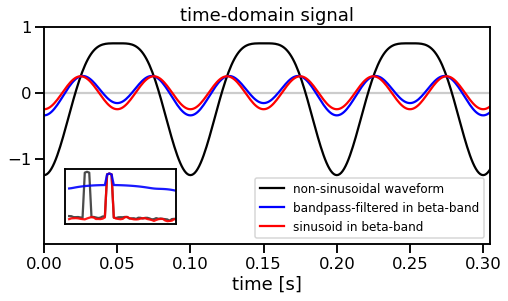

In [44]:
# plot
_, ax_ts = plt.subplots(figsize=(8, 4))

ax_ts.axhline(0, color="k", alpha=0.2)
ax_ts.plot(time - offset, signal_mu, color=mu_color, label="non-sinusoidal waveform")
ax_ts.plot(
    time - offset,
    signal_mu_filt,
    color=harmonic_color,
    label="bandpass-filtered in beta-band")
ax_ts.plot(time-offset, signal_beta, color=sinus_color, label="sinusoid in beta-band")

ax_ts.set_title("time-domain signal")
ax_ts.set_xlim(0, tmax-offset)
ax_ts.set_xlabel("time [s]")
ax_ts.set_ylim(-2.3, 1)
ax_ts.set_yticks([-1, 0, 1])
ax_ts.legend(loc="lower right", fontsize=12)

# tiny spectrum
axins = inset_axes(ax_ts, width="25%", height="25%", loc=3, borderpad=1.25)
axins.semilogy(freqs, spec_mu, color=mu_color, alpha=0.7)
axins.semilogy(freqs, spec_beta, color=sinus_color, alpha=0.9)
axins.semilogy(freqs, spec_beta_filt, color=harmonic_color, alpha=0.9)
axins.set_xlim(0, fmax)
axins.set_yticks([])
axins.set_xticks([])


plt.savefig("figures/15-time_domain.pdf", bbox_inches="tight")

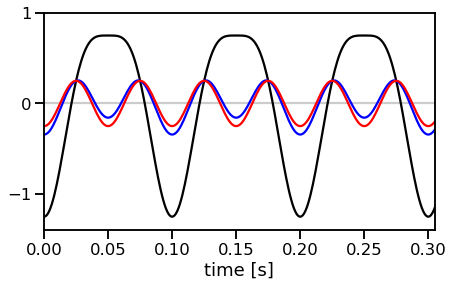

In [76]:
# plot
_, ax_ts = plt.subplots(figsize=(7, 4))

ax_ts.axhline(0, color="k", alpha=0.2)
ax_ts.plot(time - offset, signal_mu, color=mu_color, label="non-sinusoidal waveform")
ax_ts.plot(
    time - offset,
    signal_mu_filt,
    color=harmonic_color,
    label="bandpass-filtered in beta-band")
ax_ts.plot(time-offset, signal_beta, color=sinus_color, label="sinusoid in beta-band")

#ax_ts.set_title("time-domain signal")
ax_ts.set_xlim(0, tmax-offset)
ax_ts.set_xlabel("time [s]")
ax_ts.set_ylim(-1.4, 1)
ax_ts.set_yticks([-1, 0, 1])

#ax_ts.legend(loc="lower right", fontsize=12)

plt.savefig("figures/15-time_domain.pdf", bbox_inches="tight")

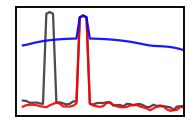

In [77]:
# tiny spectrum
#axins = inset_axes(ax_ts, width="25%", height="25%", loc=3, borderpad=1.25)
_, axins = plt.subplots(figsize=(3, 2))
axins.semilogy(freqs, spec_mu, color=mu_color, alpha=0.7)
axins.semilogy(freqs, spec_beta, color=sinus_color, alpha=0.9)
axins.semilogy(freqs, spec_beta_filt, color=harmonic_color, alpha=0.9)
axins.set_xlim(0, fmax)
axins.set_yticks([])
axins.set_xticks([])

plt.savefig("figures/15-inset_psd.pdf", bbox_inches="tight")

No handles with labels found to put in legend.


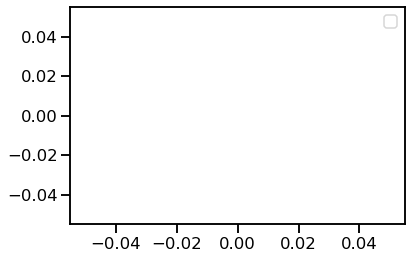

In [56]:
plt.plot()
plt.legend()

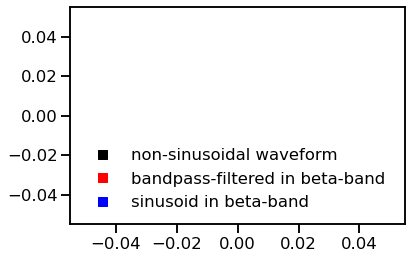

In [78]:
#colors = ["crimson", "purple", "gold"]
labels = ["non-sinusoidal waveform", "bandpass-filtered in beta-band", "sinusoid in beta-band"]

f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f("s", colors[i]) for i in range(3)]

legend = plt.legend(handles, labels, loc=3, framealpha=1, frameon=False)

def export_legend(legend, filename="legend.png"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

export_legend(legend)
plt.savefig("figures/15-legend.pdf", bbox_inches="tight")
#plt.show()

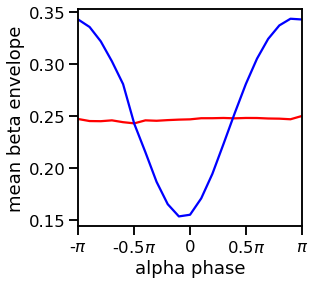

In [11]:

# PAC
_, ax_pac = plt.subplots(figsize=[4, 4])
#ax_pac = ax[1]
#ax_pac = ax

ax_pac.plot(bins, pac[:, 1], color=sinus_color)
ax_pac.plot(bins, pac[:, 0], color=harmonic_color)

#ax_pac.set_title("phase-amplitude coupling")

ax_pac.set_xticks(np.linspace(-np.pi, np.pi, 5))
ax_pac.set_xticklabels([r"-$\pi$", r"-$0.5\pi$", "0", r"$0.5\pi$", r"$\pi$"])
ax_pac.set_xlabel("alpha phase")
ax_pac.set_ylabel("mean beta envelope")
ax_pac.set_xlim(-np.pi, np.pi)

#fig.set_size_inches(8, 3.5)
#fig.tight_layout()
#fig.savefig("test.pdf", dpi=300, bbox_inches='tight')
#fig.show()

plt.savefig("figures/15-pac.pdf", bbox_inches="tight")

## WAVEFORM

/Users/tom/opt/anaconda3/lib/python3.8/site-packages/bycycle/cyclepoints.py:128: RuntimeWarning: invalid value encountered in less
  pos = data < 0
/Users/tom/opt/anaconda3/lib/python3.8/site-packages/bycycle/cyclepoints.py:117: RuntimeWarning: invalid value encountered in greater
  pos = data > 0
/Users/tom/opt/anaconda3/lib/python3.8/site-packages/bycycle/cyclepoints.py:128: RuntimeWarning: invalid value encountered in less
  pos = data < 0
/Users/tom/opt/anaconda3/lib/python3.8/site-packages/bycycle/cyclepoints.py:117: RuntimeWarning: invalid value encountered in greater
  pos = data > 0
/Users/tom/opt/anaconda3/lib/python3.8/site-packages/bycycle/cyclepoints.py:128: RuntimeWarning: invalid value encountered in less
  pos = data < 0
/Users/tom/opt/anaconda3/lib/python3.8/site-packages/bycycle/cyclepoints.py:117: RuntimeWarning: invalid value encountered in greater
  pos = data > 0
/Users/tom/opt/anaconda3/lib/python3.8/site-packages/bycycle/cyclepoints.py:128: RuntimeWarning: invali

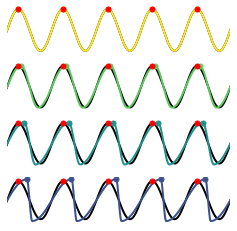

In [12]:
import numpy as np
import matplotlib.pyplot as plt

from fooof.utils import trim_spectrum
from neurodsp.filt import filter_signal
from neurodsp.sim import sim_oscillation, sim_combined, sim_powerlaw
from neurodsp.spectral import compute_spectrum
from neurodsp.utils import create_times

import bycycle.features
import seaborn as sns

np.random.seed(3)
n_seconds = 25
fs = 1000

times = create_times(n_seconds, fs)
exp = -2.0
ap_filt = (2, 150)

cf = 10
rdsym = 0.5
psd_range = (3, 35)
alpha_range = (8, 12)
beta_range = (15, 35)
rdsyms = [0.50, 0.625, 0.75, 0.875, 1.0]
comps = {
    "sim_powerlaw": {"exponent": exp, "f_range": ap_filt},
    "sim_oscillation": {"freq": cf, "cycle": "asine", "rdsym": rdsym},
}

# Define relative power of the signal components
comp_vars = [1, 0.8]
plt_kwargs = {"xlabel": "", "ylabel": "", "alpha": [0.75, 0.75]}

# Simulate an asymmetric oscillation
fig, ax = plt.subplots(4, 1, figsize=(4, 4))
rdsyms = np.arange(0.5, 0.8, 0.15)
noise = sim_powerlaw(n_seconds, fs, exponent=-2.5)

all_pows = []
rdsyms = [0.50, 0.625, 0.75, 0.875]
labels = ["rd-sym=%.3f" % i for i in rdsyms]

burst_detection_kwargs = {
    "amplitude_fraction_threshold": 0.0,
    "amplitude_consistency_threshold": 0.0,
    "period_consistency_threshold": 0.0,
    "monotonicity_threshold": 0.0,
}

cmap = [plt.cm.viridis(i) for i in np.linspace(0, 1, len(rdsyms) + 1)]
cmap = cmap[::-1]

for i, rdsym in enumerate(rdsyms):
    osc = sim_oscillation(n_seconds, fs, cf, cycle="asine", rdsym=rdsym)

    # compute peak deviation
    df = bycycle.features.compute_features(
        osc,
        fs,
        f_range=(cf - 2, cf + 2),
        burst_detection_kwargs=burst_detection_kwargs,
    )

    sig_filt_al = filter_signal(osc, fs, "bandpass", alpha_range)
    df_filt = bycycle.features.compute_features(
        sig_filt_al,
        fs,
        f_range=(cf - 2, cf + 2),
        burst_detection_kwargs=burst_detection_kwargs,
    )

    ax_time = ax[i]
    ax_time.plot(times, sig_filt_al, color="k", lw=2)
    ax_time.plot(times, osc, color=cmap[i], lw=2)

    ax_time.plot(
        times[df.sample_peak], df.volt_peak, ".", color=cmap[i], markersize=10
    )
    ax_time.plot(
        times[df_filt.sample_peak], df_filt.volt_peak, "r.", markersize=10
    )

    # cheating because the noise is added only here
    osc += 20 * noise
    cur_freqs, cur_pows = compute_spectrum(osc, fs, nperseg=1.5 * fs)
    all_pows.append(cur_pows)
    ax_time.axis("off")
    ax_time.set(xlim=(4.5, 5), ylim=(-1.6, 1.6))

plt.savefig("figures/15-ts_all.pdf", bbox_inches="tight")

In [13]:
freqs, psd = trim_spectrum(cur_freqs, np.array(all_pows), psd_range)

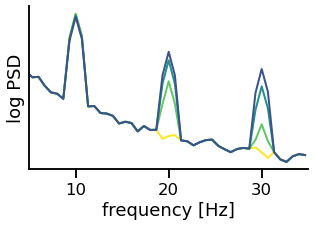

In [14]:
# plot spectra
#fig, ax = plt.subplots(2, 1, figsize=(3, 4))
#ax_psd = ax[0]
_, ax_psd = plt.subplots(figsize=(5, 3))

for i in range(4):
    ax_psd.semilogy(freqs, psd[i].T, color=cmap[i], lw=2)
ax_psd.set(xlabel="frequency [Hz]", xlim=(5, 35), yticks=[], ylabel="log PSD")
sns.despine(ax=ax_psd)

plt.savefig("figures/15-psd_all.pdf", bbox_inches="tight")

In [15]:
# simulate for a number of trials
nr_trials = 50
rdsyms = np.arange(0.5, 1, 0.025)
beta_pows = np.zeros((len(rdsyms), nr_trials))

for i_rdsym, rdsym in enumerate(rdsyms):

    for i_trial in range(nr_trials):

        # Create the signal
        comps = {
            "sim_powerlaw": {"exponent": exp, "f_range": ap_filt},
            "sim_oscillation": {"freq": cf, "cycle": "asine", "rdsym": rdsym},
        }

        cur_sig = sim_combined(n_seconds, fs, comps, comp_vars)

        # Compute the spectrum and collect the measured beta power
        cur_freqs, cur_pows = compute_spectrum(cur_sig, fs, nperseg=fs)
        _, beta_pow = trim_spectrum(cur_freqs, cur_pows, beta_range)
        beta_pow = np.mean(beta_pow)
        beta_pows[i_rdsym, i_trial] = beta_pow


mean_beta = np.mean(beta_pows, axis=1)
std_beta = np.std(beta_pows, axis=1)

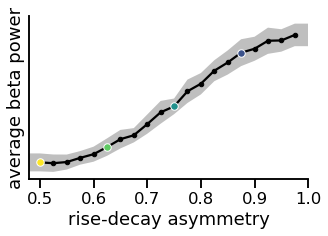

In [16]:
_, ax_sym = plt.subplots(figsize=(5, 3))
#ax_sym = ax[1]

ax_sym.plot(rdsyms, mean_beta, "k.-")

rdsyms_selected = [0.50, 0.625, 0.75, 0.875]
for i, rd in enumerate(rdsyms_selected):
    idx = np.argmin(np.abs(rdsyms - rd))
    ax_sym.plot(
        rdsyms[idx],
        mean_beta[idx],
        ".",
        color=cmap[i],
        markersize=15,
        markeredgecolor="w",
    )


# solely for prettier error spans
rdsyms = np.hstack([0.48, rdsyms, 1.0])
mean_beta = np.hstack([mean_beta[0], mean_beta, mean_beta[-1]])
std_beta = np.hstack([std_beta[0], std_beta, std_beta[-1]])

ax_sym.fill_between(
    rdsyms,
    mean_beta - std_beta,
    mean_beta + std_beta,
    facecolor="k",
    alpha=0.25,
    edgecolor=None,
)
ax_sym.set(
    xlabel="rise-decay asymmetry",
    xticks=np.arange(0.5, 1.01, 0.1),
    ylabel="average beta power",
    yticks=[],
    xlim=(0.48, 1.0),
)
sns.despine(ax=ax_sym)

plt.savefig("figures/15-psd_shapes.pdf", bbox_inches="tight")